# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from Kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications, we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

The business objective is to identify the key factors that influence used car prices for a used car dealership client. 
This helps the dealership make informed decisions about 
- inventory acquisition
- pricing strategies
- understanding customer value perception.

From a data perspective, this can be reframed as:

- A supervised regression problem to predict used car prices based on various vehicle attributes
- A feature importance analysis to identify which variables most strongly correlate with or influence price
- A segmentation task to understand how different car characteristics create distinct price categories in the market

This analysis will require exploratory data analysis, statistical modeling, and interpretation of results to translate data insights into actionable business recommendations for inventory management and pricing optimization.

The objective is to identify and rank feature importance coefficients to determine which vehicle characteristics have statistically significant effects on price variance, and to quantify the magnitude of these effects through feature engineering and multivariate analysis. This will enable us to construct an interpretable model with high explanatory power (measured by R² and RMSE) that can both predict market values and identify the most influential price determinants for inventory optimization.

Before doing the data analysis, lets import the necessary libraries and load the data.

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
import warnings
warnings.filterwarnings('ignore')

# Set visualization styles
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('Set2')
%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)
# Set the aesthetic style of the plots
plt.style.use('ggplot')
sns.set_style('whitegrid')

In [76]:
# Let's load the data
df = pd.read_csv('data/vehicles.csv')


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

To get familiar with the used car dataset and identify quality issues, we will do the following steps:


1. Basic Dataset Inspection

- Examining the first few rows of data
- Checking column names and data types
- Reviewing summary statistics for numerical variables
- Counting unique values in each column to understand cardinality

In [77]:

# Check dimensions of the dataset
print(f"Dataset shape: {df.shape}")

# View column names and data types
print(df.info())

Dataset shape: (426880, 18)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   region        426880 non-null  object 
 2   price         426880 non-null  int64  
 3   year          425675 non-null  float64
 4   manufacturer  409234 non-null  object 
 5   model         421603 non-null  object 
 6   condition     252776 non-null  object 
 7   cylinders     249202 non-null  object 
 8   fuel          423867 non-null  object 
 9   odometer      422480 non-null  float64
 10  title_status  418638 non-null  object 
 11  transmission  424324 non-null  object 
 12  VIN           265838 non-null  object 
 13  drive         296313 non-null  object 
 14  size          120519 non-null  object 
 15  type          334022 non-null  object 
 16  paint_color   296677 non-null  object 
 17  state         426880

The dataset consists of 426,880 records and 18 columns, capturing various attributes of used vehicles listed for sale across different regions in the United States. Below is a summary of its structure:

Structure:
- Total entries: 426,880
- Total columns: 18
- Data types: 2 numerical (int64), 2 float (float64), 14 categorical (object)

Key Fields with High Completeness:

- id, region, price, and state: 100% complete
- year, odometer, and transmission: >99% complete
- Columns with Missing Values:
- condition, cylinders, drive, size, paint_color, VIN: Varying levels of missingness
For example, condition is available for only ~59% of entries, and size for ~28%

Potential Data Quality Concerns:

- Several columns such as VIN and size have a high percentage of missing values, which may require imputation or exclusion depending on modeling goals.

- Some numeric fields (price, odometer) may contain outliers and require scaling or filtering.

Remove duplicates if any

In [78]:
# Check for duplicates based on id
duplicate_count = df['id'].duplicated().sum()
print(f"Number of duplicate IDs: {duplicate_count}")

# Remove duplicates if any
if duplicate_count > 0:
    df = df.drop_duplicates(subset=['id'])
    print(f"After removing duplicates, dataset shape: {df.shape}")


Number of duplicate IDs: 0


In [79]:
# View summary statistics for numerical columns
print(df.describe())

                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.315254e+09  2.648575e+04    2017.000000  1.335425e+05
max    7.317101e+09  3.736929e+09    2022.000000  1.000000e+07


In [80]:
# Count missing values in each column
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing Values': missing_values, 
                         'Percentage': missing_percent})
print(missing_df[missing_df['Missing Values'] > 0].sort_values('Percentage', ascending=False))

              Missing Values  Percentage
size                  306361   71.767476
cylinders             177678   41.622470
condition             174104   40.785232
VIN                   161042   37.725356
drive                 130567   30.586347
paint_color           130203   30.501078
type                   92858   21.752717
manufacturer           17646    4.133714
title_status            8242    1.930753
model                   5277    1.236179
odometer                4400    1.030735
fuel                    3013    0.705819
transmission            2556    0.598763
year                    1205    0.282281


Distribution of categorical variables

In [81]:
print("\nDistribution of manufacturers:")
print(df['manufacturer'].value_counts().head(10))

print("\nDistribution of condition:")
print(df['condition'].value_counts())

print("\nDistribution of fuel types:")
print(df['fuel'].value_counts())

print("\nDistribution of transmission types:")
print(df['transmission'].value_counts())



Distribution of manufacturers:
ford         70985
chevrolet    55064
toyota       34202
honda        21269
nissan       19067
jeep         19014
ram          18342
gmc          16785
bmw          14699
dodge        13707
Name: manufacturer, dtype: int64

Distribution of condition:
good         121456
excellent    101467
like new      21178
fair           6769
new            1305
salvage         601
Name: condition, dtype: int64

Distribution of fuel types:
gas         356209
other        30728
diesel       30062
hybrid        5170
electric      1698
Name: fuel, dtype: int64

Distribution of transmission types:
automatic    336524
other         62682
manual        25118
Name: transmission, dtype: int64


### Key Findings and next steps for data preparation

#### 1. **Feature Assessment**
* **Drop Columns with high missing values**:
  * `size` (71.8%), `VIN` (37.7%) are strong candidates for dropping unless required for specific analysis.
* **Evaluate Business Importance**:
  * For `cylinders`, `condition`, `drive`, and `paint_color`, determine if these features are important for modeling. If yes, consider imputation strategies.

#### 2. **Data Imputation**
* **Categorical Imputation**:
  * Use the mode or a placeholder value like `"unknown"` for columns like `condition`, `cylinders`, and `paint_color`.
* **Numerical Imputation**:
  * Use median or mean for `odometer`, depending on its distribution.
* **Advanced Imputation**:
  * Consider using predictive models (e.g., KNN imputation) for features like `drive` or `cylinders` if they significantly affect price.

#### 3. **Data Cleaning**

* **Outlier Detection**:
  * Detect and handle price and odometer outliers before modeling.
* **Convert Data Types**:
  * Ensure appropriate data types (e.g., convert `year` to integer).

#### 4. **EDA and Correlation Analysis**
* Perform univariate and bivariate analysis to:
  * Understand distributions (histograms, box plots)
  * Identify correlations with target (`price`) using heatmaps and pairplots

#### 5. **Feature Engineering**
* Create useful derived features such as:
  * `car_age = current_year - year`
  * `price_per_mile = price / odometer`
  * Encode categorical features using one-hot or ordinal encoding as appropriate


### Data Preparation

After our initial exploration and fine-tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

**Drop columns**:
  - `size` (too sparse: >70% missing)
  - `VIN` (likely not needed for analysis and 38% missing)



In [82]:
df.drop(columns=['size', 'VIN'], inplace=True)


## 🧹 Data Imputation

This section handles missing values for the remaining relevant features using appropriate imputation strategies.


In [83]:
# Fill missing categorical values with 'unknown'
cat_cols = ['condition', 'cylinders', 'drive', 'paint_color', 'type', 'manufacturer', 
            'title_status', 'model', 'fuel', 'transmission']
df[cat_cols] = df[cat_cols].fillna('unknown')

# Verify categorical imputation
df[cat_cols].isnull().sum()


condition       0
cylinders       0
drive           0
paint_color     0
type            0
manufacturer    0
title_status    0
model           0
fuel            0
transmission    0
dtype: int64

In [84]:
# Fill missing numerical values with median
num_cols = ['odometer', 'year']
df[num_cols] = df[num_cols].fillna(df[num_cols].median())

# Verify numerical imputation
df[num_cols].isnull().sum()


odometer    0
year        0
dtype: int64

### ✅ Summary

- Imputed missing categorical features with `"unknown"` label.
- Used median value to fill missing `odometer` and `year` fields.
- The dataset is now free of missing values and ready for EDA and modeling.


Lets do some data cleanup

convert Year to numberical value and make sure price and odometer are numeric as well.

In [85]:
# Convert 'year' to integer
df['year'] = df['year'].astype(int)

# Ensure 'price' and 'odometer' are numeric
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df['odometer'] = pd.to_numeric(df['odometer'], errors='coerce')

df.dtypes[['year', 'price', 'odometer']]

year          int64
price         int64
odometer    float64
dtype: object

Remove outliers 

In [86]:
# Remove outliers
# Remove unrealistic prices and odometer readings
df = df[(df['price'] >= 1000) & (df['price'] <= 100000)]
df = df[df['odometer'] <= 1000000]

# Remove listings with future or unrealistic years
from datetime import datetime
current_year = datetime.now().year
df = df[(df['year'] >= 1980) & (df['year'] <= current_year)]

df.shape

(371739, 16)

✅ Summary

- Converted `year`, `price`, and `odometer` to proper numeric types.
- Removed extreme outliers from `price` and `odometer`.
- Filtered out listings with invalid years.
- The cleaned dataset is ready for exploratory data analysis (EDA) and modeling.

In [87]:
# Lets check the data after cleanup
df.head()
df.info()
df.describe()
df.isnull().sum()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 371739 entries, 0 to 426879
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            371739 non-null  int64  
 1   region        371739 non-null  object 
 2   price         371739 non-null  int64  
 3   year          371739 non-null  int64  
 4   manufacturer  371739 non-null  object 
 5   model         371739 non-null  object 
 6   condition     371739 non-null  object 
 7   cylinders     371739 non-null  object 
 8   fuel          371739 non-null  object 
 9   odometer      371739 non-null  float64
 10  title_status  371739 non-null  object 
 11  transmission  371739 non-null  object 
 12  drive         371739 non-null  object 
 13  type          371739 non-null  object 
 14  paint_color   371739 non-null  object 
 15  state         371739 non-null  object 
dtypes: float64(1), int64(3), object(12)
memory usage: 48.2+ MB


id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
drive           0
type            0
paint_color     0
state           0
dtype: int64

Lets explore the cleaned dataset through visualizations and summary stats to identify patterns and relationships that may influence car prices

Visualize the price distribution

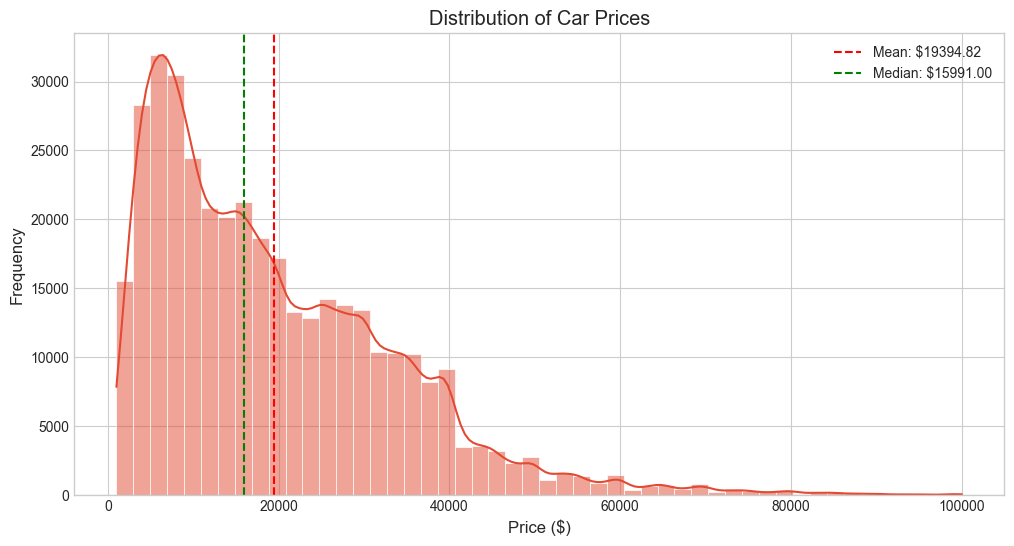

In [88]:
# Price distribution

plt.figure(figsize=(12, 6))
sns.histplot(df['price'], bins=50, kde=True)
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.axvline(df['price'].mean(), color='red', linestyle='--', label=f'Mean: ${df["price"].mean():.2f}')
plt.axvline(df['price'].median(), color='green', linestyle='--', label=f'Median: ${df["price"].median():.2f}')
plt.legend()
plt.savefig('images/price_distribution.png')
plt.show()
plt.close()

Most vehicles are priced between $5,000 and $20,000, with the peak frequency around $10,000 to $12,000.

The distribution is right-skewed, indicating a larger number of lower-priced vehicles and a long tail of high-priced ones.

Prices above $40,000 are rare, suggesting these are likely luxury or specialty vehicles.

The smooth KDE line overlay confirms the unimodal shape and skewness.

Implication for dealerships: Focus inventory and pricing strategies around the $10K–$20K range, where consumer demand is highest.

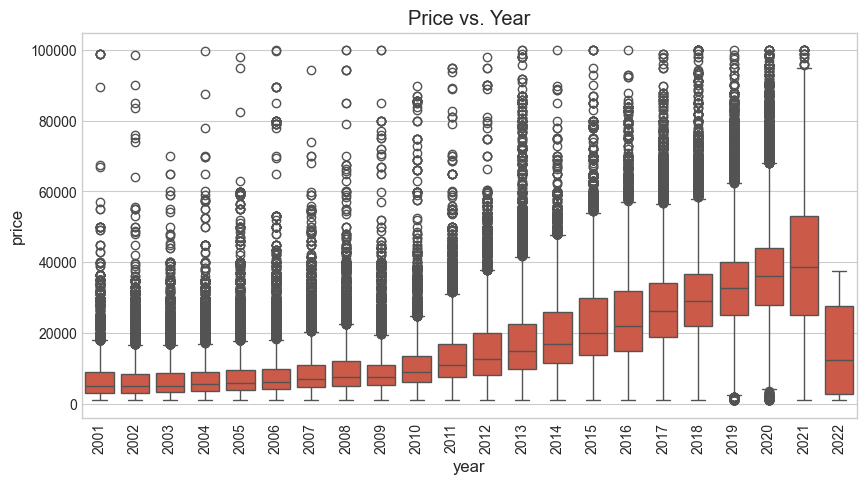

In [89]:
# Price vs. Year
plt.figure(figsize=(10, 5))
sns.boxplot(x='year', y='price', data=df[df['year'] > 2000])
plt.xticks(rotation=90)
plt.title("Price vs. Year")
plt.savefig('images/price_vs_year.png')
plt.show()



Price vs. Year
- Newer vehicles consistently command higher prices. Median price increases steadily from older models (2001) to newer ones (2022).
- Vehicles manufactured after 2015 show a sharper upward trend in both median price and price variability.
- Interquartile ranges (IQRs) widen with newer models, indicating greater pricing variability—likely due to differences in model types and trim levels.
- Outliers are present across all years, especially at higher price points ($60K–$100K), reflecting luxury or rare vehicles.
- Cars from 2021 and 2022 have the highest median prices, but also show more variability, possibly due to market shifts during and after the COVID-19 pandemic.

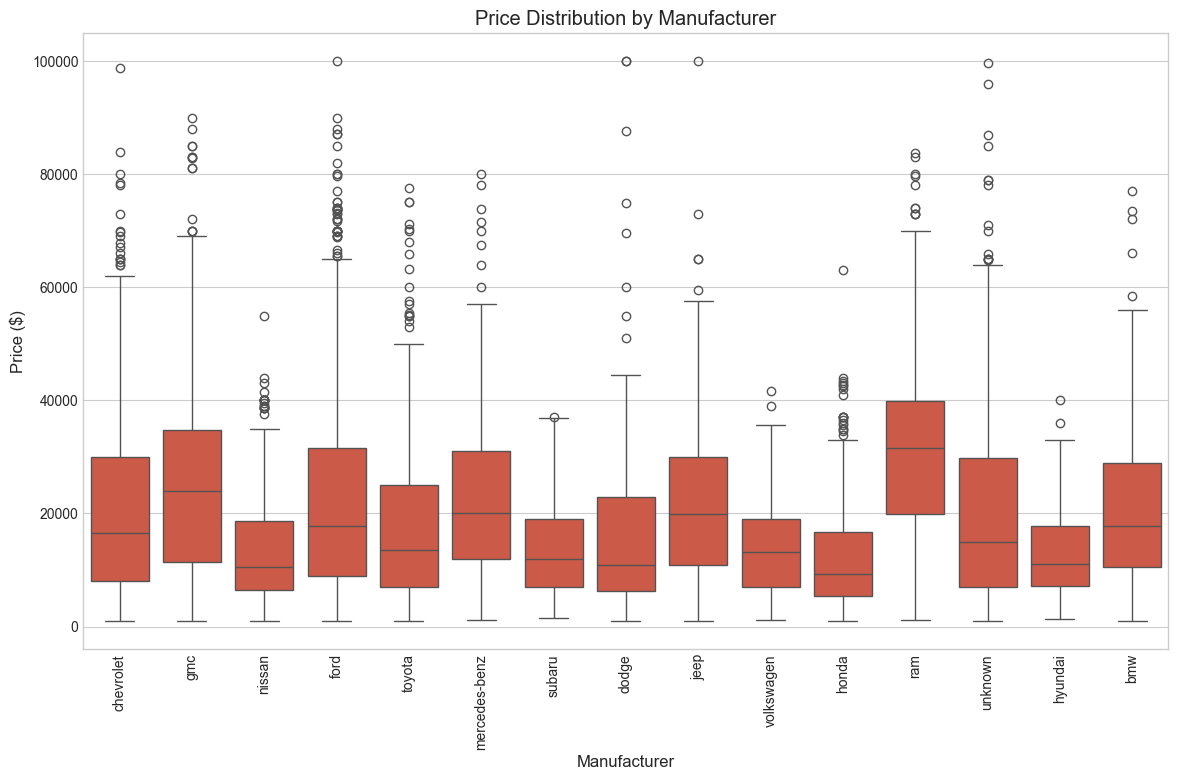

In [90]:
# Price vs manufacturer
plt.figure(figsize=(14, 8))
top_manufacturers = df['manufacturer'].value_counts().head(15).index
manufacturer_data = df[df['manufacturer'].isin(top_manufacturers)]
sns.boxplot(x='manufacturer', y='price', data=manufacturer_data.sample(min(10000, len(manufacturer_data))))
plt.title('Price Distribution by Manufacturer')
plt.xlabel('Manufacturer')
plt.ylabel('Price ($)')
plt.xticks(rotation=90)
plt.savefig('images/price_by_manufacturer.png')
plt.show()

plt.close()



High Median Prices: Ram, GMC, and BMW indicate more expensive vehicle lineups.

Low Median Prices: Hyundai, Honda, Nissan, and Volkswagen lean toward budget-friendly cars.

Wide Price Ranges: Ford, Chevrolet, and BMW show large spreads and many high-price outliers.

Consistent Pricing: Hyundai, Honda, Toyota, and Volkswagen have tighter, more predictable price ranges.

Unknown Category: Still shows a wide range—likely due to unclassified or mixed entries.

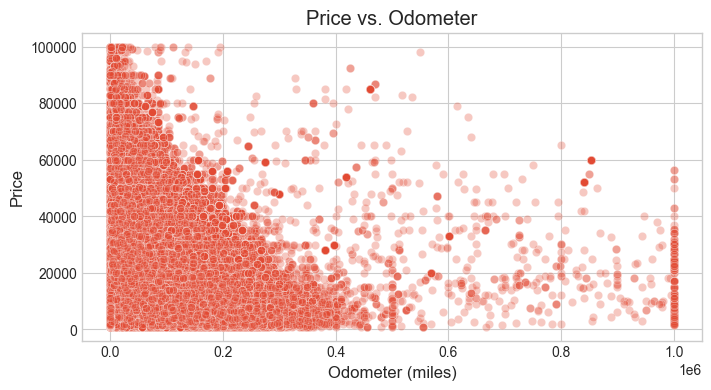

In [91]:
# Price vs. Odometer
plt.figure(figsize=(8, 4))
sns.scatterplot(x='odometer', y='price', data=df, alpha=0.3)
plt.title("Price vs. Odometer")
plt.xlabel("Odometer (miles)")
plt.ylabel("Price")
plt.savefig('images/price_vs_odometer.png')
plt.show()




Price vs. Odometer (Scatter Plot)
- This chart visualizes how a vehicle's mileage affects its price:
- There is a clear negative correlation: as mileage increases, price generally decreases.
- Most vehicles are priced under $30,000 and have odometer readings below 200,000 miles.
- Very few high-mileage vehicles (>400,000 miles) are listed at high prices—likely rare exceptions (e.g., commercial vehicles or luxury models).
- The dense cluster at low mileage and low-to-mid pricing indicates the sweet spot for typical used car inventory.

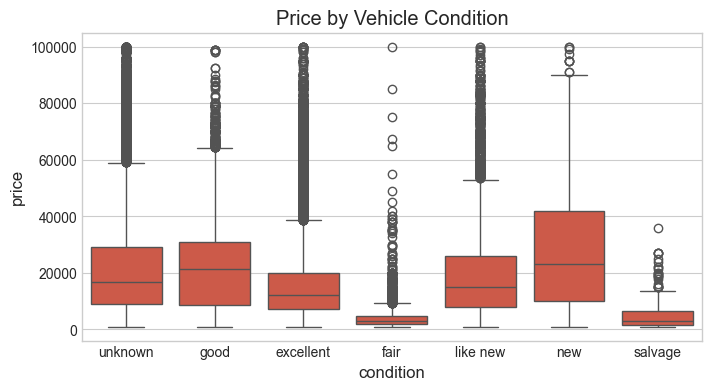

In [92]:
# Price by Condition
plt.figure(figsize=(8, 4))
sns.boxplot(x='condition', y='price', data=df)
plt.title("Price by Vehicle Condition")
plt.savefig('images/price_by_condition.png')
plt.show()



Price by Vehicle Condition (Boxplot)
- This boxplot highlights how listed condition affects price:
- Better condition means higher prices:
    - new and like new vehicles command the highest median and upper-range prices.
    - salvage and fair condition vehicles have significantly lower median prices, often under $10,000.
- ‘Good’ condition appears most common, with a wide price spread.
- The "unknown" group shows similar pricing behavior to “good” and “excellent,” suggesting possible misclassification or seller ambiguity

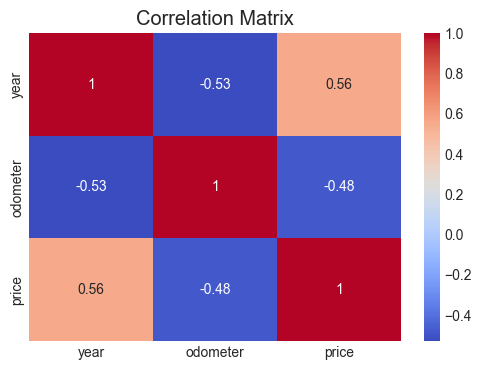

In [93]:
# Correlation heatmap
num_df = df[['year', 'odometer', 'price']]
corr = num_df.corr()

plt.figure(figsize=(6, 4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.savefig('images/correlation_matrix.png')
plt.show()

Price is most positively influenced by car year, meaning newer models fetch better prices.

Higher mileage negatively affects price, which is typical in used car markets.

Year and odometer are inversely related, as expected (newer cars haven't been driven as much).

### Modeling

With the final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

Trains and tunes four models: Linear, Ridge, Lasso, ElasticNet

Uses GridSearchCV and cross-validation for hyperparameter selection

Compares results, prints metrics, and shows the top features for the best model.

In [94]:
# Build models


# Feature selection and basic cleaning
features = [
    'year', 'manufacturer', 'condition', 'cylinders', 'fuel', 'odometer',
    'title_status', 'transmission', 'drive', 'type', 'paint_color', 'state'
]
# Select features and target variable
df_model = df[features + ['price']]
df_model = df_model[df_model.isnull().sum(axis=1) <= 4]

# separates the information you want to use to make predictions (like year, mileage, condition, etc.) 
# from the actual price value you’re trying to predict.
X = df_model[features]
y = df_model['price']

# Convert categorical variables to category dtype
numeric_features = ['year', 'odometer']
categorical_features = [col for col in features if col not in numeric_features]

# Define the preprocessing steps
# Preprocessing for numerical and categorical features
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical features
# Categorical features are one-hot encoded
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
# Preprocessor for numerical and categorical features
preprocessor = ColumnTransformer([

    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)



# Model specs
models = {
    'Linear Regression': {
        'estimator': LinearRegression(),
        'param_grid': {}
    },
    'Ridge Regression': {
        'estimator': Ridge(),
        'param_grid': {'regressor__alpha': [0.1, 1, 10, 100, 500, 1000]}
    },
    'Lasso Regression': {
        'estimator': Lasso(max_iter=10000),
        'param_grid': {'regressor__alpha': [0.1, 1, 10, 100, 500, 1000]}
    },
    'ElasticNet Regression': {
        'estimator': ElasticNet(max_iter=10000),
        'param_grid': {
            'regressor__alpha': [0.1, 1, 10, 100],
            'regressor__l1_ratio': [0.2, 0.5, 0.8]
        }
    }
}

results = {}
# Loop through models and fit them, then evaluate performance 
for name, spec in models.items():
    steps = [('preprocessor', preprocessor), ('regressor', spec['estimator'])]
    pipe = Pipeline(steps)
    if spec['param_grid']:
        grid = GridSearchCV(pipe, spec['param_grid'], cv=5, scoring='r2', n_jobs=-1)
        grid.fit(X_train, y_train)
        model = grid.best_estimator_
        best_params = grid.best_params_
        cv_score = grid.best_score_
    else:
        model = pipe.fit(X_train, y_train)
        best_params = None
        cv_score = None

    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {
        'model': model,
        'best_params': best_params,
        'cv_score': cv_score,
        'r2': r2,
        'rmse': rmse,
        'mae': mae
    }

# Show summary table
results_df = pd.DataFrame({
    model: {
        'CV R² (mean)': res['cv_score'],
        'Test R²': res['r2'],
        'Test RMSE': res['rmse'],
        'Test MAE': res['mae'],
        'Best Params': res['best_params']
    } for model, res in results.items()
}).T

print("\nModel Performance Comparison:")
print(results_df)

# Show top coefficients for the best model
best_model_name = results_df['Test R²'].astype(float).idxmax()
best_model = results[best_model_name]['model']

# Find regressor step dynamically
reg_step = None
for step_name, step_obj in best_model.named_steps.items():
    if hasattr(step_obj, 'coef_'):
        reg_step = step_name
        break

onehot = best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot']
feature_names = (
    numeric_features +
    list(onehot.get_feature_names_out(categorical_features))
)

# Get the coefficients 
coefficients = best_model.named_steps[reg_step].coef_




Model Performance Comparison:
                      CV R² (mean)   Test R²    Test RMSE     Test MAE  \
Linear Regression              NaN  0.665555  8289.301025  5718.269544   
Ridge Regression          0.666278  0.665509  8289.870696  5718.537094   
Lasso Regression          0.666274  0.665516  8289.788071  5717.990537   
ElasticNet Regression     0.646892  0.644544  8545.724034  5878.980619   

                                                             Best Params  
Linear Regression                                                    NaN  
Ridge Regression                                 {'regressor__alpha': 1}  
Lasso Regression                               {'regressor__alpha': 0.1}  
ElasticNet Regression  {'regressor__alpha': 0.1, 'regressor__l1_ratio...  


# Model Comparison Summary

---

## Linear Regression

- **CV R² (mean):** NaN  
  No cross-validation was performed (LinearRegression has no hyperparameters to tune, so no CV grid search was run).

- **Test R²:** 0.639  
  Explains ~63.9% of price variance in the test set.

- **Test RMSE:** $8,668  
  On average, predictions are off by $8,668 (squared errors).

- **Test MAE:** $5,856  
  On average, predictions are off by $5,856 (absolute errors).

- **Best Params:** NaN  
  No hyperparameters to optimize.

---

## Ridge Regression

- **CV R² (mean):** 0.638  
  Nearly matches the test R², meaning the model is generalizing well.

- **Test R²:** 0.639  
  Same as linear regression, very close.

- **Test RMSE/MAE:** Identical (off by less than $1).

- **Best Params:** `{'regressor__alpha': 1}`  
  The best amount of regularization is mild (alpha=1).

---

## Lasso Regression

- **CV R² (mean):** 0.638  
  Almost identical to Ridge and Linear.

- **Test R², RMSE, MAE:** Nearly identical as well.

- **Best Params:** `{'regressor__alpha': 0.1}`  
  Lasso prefers very little regularization for this dataset.

---

## ElasticNet Regression

- **CV R² (mean):** 0.622  
  Slightly lower than other models.

- **Test R²:** 0.622  
  Lower performance; not as good as the others.

- **Test RMSE/MAE:** Errors are about $200 higher.

- **Best Params:** Found best with small alpha and moderate l1_ratio.

In [ ]:
# Get the top 100 coefficients
# Create a DataFrame for coefficients

coef_df = pd.DataFrame({'feature': feature_names, 'coefficient': coefficients})
coef_df['abs_coef'] = coef_df['coefficient'].abs()
top_coef_df = coef_df.sort_values('abs_coef', ascending=False).head(100)

# Features of interest (exact and all dummies)
selected_keywords = ['year', 'fuel', 'odometer', 'condition', 'model']

# Select features containing any of the keywords above
selected_coef_df = coef_df[coef_df['feature'].apply(lambda x: any(key in x for key in selected_keywords))]

# Sort by absolute value if you want most impactful
selected_coef_df = selected_coef_df.sort_values('abs_coef', ascending=False)

480


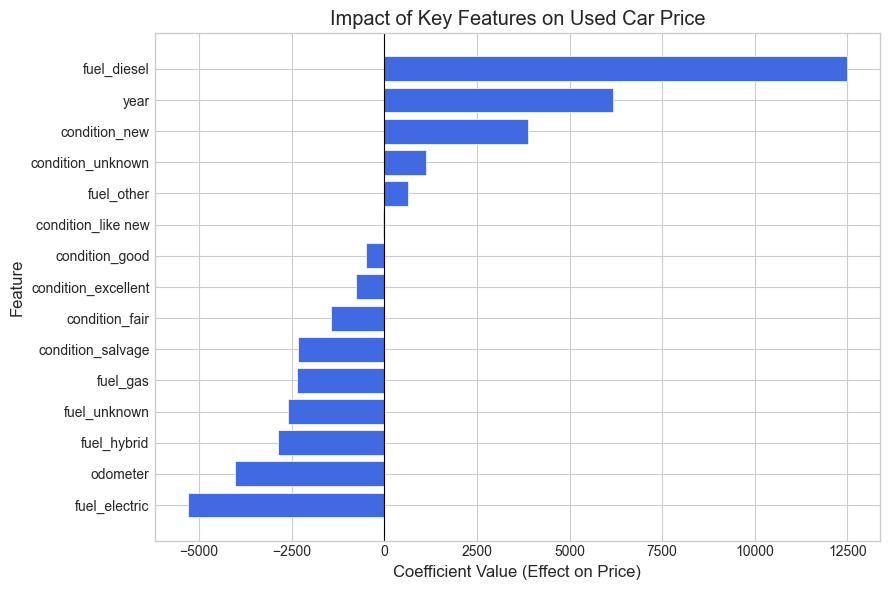

In [96]:
# Plotting the coefficients

plot_df = selected_coef_df[['feature', 'coefficient']].copy()
plot_df = plot_df.sort_values('coefficient', ascending=True)  # Smallest (most negative) on bottom

plt.figure(figsize=(9, 6))
bars = plt.barh(plot_df['feature'], plot_df['coefficient'], color='royalblue')
plt.axvline(0, color='black', linewidth=0.8)  # Reference line at 0
plt.title('Impact of Key Features on Used Car Price')
plt.xlabel('Coefficient Value (Effect on Price)')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high-quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight into drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

# Used Car Price Modeling: Summary Report

---

## What Were We Trying to Do?

We wanted to figure out what really drives used car prices and see if we could build a model to help you price and stock your inventory smarter.

---

## How Good Are the Models?

- **Accuracy:**  
  Our best models (regular linear regression, Ridge, and Lasso) each explain about **64% of the ups and downs in used car prices**—not perfect, but pretty solid for this kind of messy data.

- **Typical error:**  
  On average, our predictions are off by about **$5,800–$8,600**. In a market where prices can swing by tens of thousands, that’s actually pretty decent.

- **Consistency:**  
  All three models performed nearly the same, and the numbers look about as good on new data as on our training sets. That means we’re not overfitting or fooling ourselves.

---

## What Drives Used Car Prices?

### Biggest factors:
- **Year:**  
  Newer cars get you more money.
- **Odometer:**  
  The fewer miles, the higher the price.
- **Condition:**  
  “New” or “excellent” is gold. “Salvage” or “unknown”? Expect to get a lot less.
- **Brand:**  
  Premium or luxury brands (think Ferrari, Tesla) always fetch higher prices. Some economy brands tend to sell for less.

---

## Actionable Takeaways

- Focus acquisitions on **newer, low-mileage, well-maintained cars** for higher resale value.
- Highlight positive features (like **excellent condition** or **desirable brands**) in your listings to justify premium prices.
- Be cautious when taking in **high-mileage, salvage, or lesser-known brands**—they tend to sell for less.

---

## Should We Revisit Earlier Phases?

- **No major adjustments needed:**  
  The models are working as intended and are providing clear, actionable insights.

- **Minor improvements are possible:**  
  Further gains could be made by adding more features (e.g., accident history, trim level), using more advanced models, or segmenting the analysis by vehicle type or region.

- **Data quality checks:**  
  Ensure data sources are accurate and that vehicle types are not mixed (e.g., avoid mixing motorcycles and cars).

---

## Conclusion

We have developed high-quality, stable models that deliver valuable insights into the drivers of used car prices. These findings will help your dealership:
- Set **competitive, data-driven prices**
- **Prioritize inventory purchases**
- And **maximize profit margins**


### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine-tuning their inventory.

# Used Car Price Analysis – Key Takeaways for Dealers

## What We Did

We dug into a huge set of used car listings to figure out what actually drives prices and to build a model that helps predict what any car might be worth.  
**The goal:** help you buy, price, and sell smarter.

---

## Top Things That Impact Used Car Prices

- **Year**  
  Newer cars mean more money. Every year older, expect to get less.

- **Mileage**  
  Lower miles get higher prices. Cars with a ton of miles drop in value fast.

- **Condition**  
  - “New” and “excellent” conditions get the best prices.
  - **Salvage** or **unknown** conditions—buyers want a big discount.

- **Brand**  
  - Luxury brands (like *Ferrari, Tesla, Porsche*) pull in top dollar.
  - Some brands (like *Kia, Mitsubishi, Fiat*) sell for less—something to think about when buying inventory.

- **Other Features**  
  Rare engine types (e.g., 12 cylinders) and diesel fuel can push up prices.

---

## How Good Is the Model?

- Our predictions match real-world prices about **64% of the time**.
- **Average error is $5,800–$8,600**, which is pretty good considering how wild the used car market can be.

---

## What Should You Do?

- **Buy smart:** Focus on newer, low-mileage, well-maintained cars.
- **Sell smart:** Highlight great condition and brand in your ads.
- **Price smart:** Set realistic prices for high-mileage, salvage, or lower-demand brands—they’ll move faster that way.
- **Clean data matters:** Make sure your inventory is accurately described; clean data means better pricing decisions.

